In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("Datasets/intel/"))

# Any results you write to the current directory are saved as output.

['seg_pred', 'seg_train', 'seg_test']


In [2]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [3]:
import torch.utils.data as tdata

In [4]:
data_path_format = 'Datasets/intel/seg_{0}/seg_{0}'

In [ ]:
!tre

In [5]:
np.random.seed(5315)
torch.manual_seed(9784)

In [6]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [7]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [8]:
image_datasets = dict(zip(('dev', 'test'),
                          [datasets.ImageFolder(data_path_format.format(key),
                                                transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: Datasets/intel/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: Datasets/intel/seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )}


In [31]:
image_datasets['validation'][5][0].size()

torch.Size([3, 150, 150])

In [30]:
image_datasets['dev'].classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [11]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [12]:
from sklearn import model_selection

In [13]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [14]:
print(len(val_indices))

1404


In [15]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [16]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: Datasets/intel/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: Datasets/intel/seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'train': <torch.utils.data.dataset.Subset object at 0x7fa18c9fb050>, 'validation': <torch.utils.data.dataset.Subset object at 0x7fa18cc8cfd0>}


In [17]:
from IPython.display import display

In [20]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

/home/ivan/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


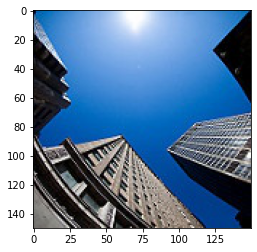

In [24]:
imshow(image_datasets['train'][1024][0]) # 5946

In [32]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [34]:
image_datasets['dev'].classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
(10, 3,150,150)  -> (10, 3*150*150)

In [35]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(3*150*150,6)
        
    def forward(self, X):
        X = X.view(X.size(0),-1)
        logits = self.fc(X) # B x 6
        return logits
        

In [77]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
#         self.conv1 = nn.Conv2d(3,64,5,padding=2)
#         self.relu1 = nn.ReLU()
        self.block = nn.Sequential(
            nn.Conv2d(3,64,5,padding=2),
            nn.ReLU(),
            nn.Conv2d(64,80,7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(80, 100, 5),
            nn.ReLU(),
            nn.Conv2d(100,200, 3)
        )
    
        self.fc = nn.Linear(200,6)
        
        
    def forward(self, X):
        # B x C x H x W
        X = self.block(X)
        X = X.view(X.size(0),X.size(1),-1)
        X = X.mean(dim=-1) # B x 200
        logits = self.fc(X)
        return logits # B x 6

In [96]:
class ResnetBasedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.ptr = models.resnet18(pretrained=True)
        for param in self.ptr.parameters():
            param.requires_grad = False
        num_ftrs = self.ptr.fc.in_features
        self.ptr.fc = nn.Identity()
        
        self.fc = nn.Linear(num_ftrs, 6)
        
    def encode(self, X):
        return self.ptr(X)
    
    def forward(self, X):
        return self.fc(self.encode(X))

In [97]:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [98]:
# ptr = models.resnet18(pretrained=True)
# for param in ptr.parameters():
#     param.requires_grad = False
# num_ftrs = ptr.fc.in_features
# ptr.fc = nn.Linear(num_ftrs, 6)
# ptr = ptr.to(device)

model = ResnetBasedModel().to(device)

In [99]:
# image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}
image_dataloaders['train'] = tdata.DataLoader(image_datasets['train'], batch_size=32,shuffle=True)
image_dataloaders['validation'] = tdata.DataLoader(image_datasets['validation'], batch_size=32,shuffle=False)
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [100]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [82]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                
            
        

In [83]:
import time
start = time.time()

In [101]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(20, model, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 78 training_loss 1.4233122083205212
Epoch 0, iteration 157 training_loss 0.9004162036919896
Epoch 0, iteration 236 training_loss 0.7078080388564097
Epoch 0, iteration 315 training_loss 0.5917904192133795
Epoch 0, iteration 394 training_loss 0.5425769049155561
Epoch 0, val_loss 0.44954613934863696, accuracy = 0.8732193732193733
Epoch 1, iteration 78 training_loss 0.5014546785173537
Epoch 1, iteration 157 training_loss 0.467154607365403
Epoch 1, iteration 236 training_loss 0.4294007771377322
Epoch 1, iteration 315 training_loss 0.4243804884107807
Epoch 1, iteration 394 training_loss 0.42952535537224784
Epoch 1, val_loss 0.35037820278243587, accuracy = 0.8846153846153846
Epoch 2, iteration 78 training_loss 0.39189071764674366
Epoch 2, iteration 157 training_loss 0.38083426767512213
Epoch 2, iteration 236 training_loss 0.38957070927076703
Epoch 2, iteration 315 training_loss 0.37309998613369616
Epoch 2, iteration 394 training_loss 0.392478236291982
Epoch 2, val_loss 0.31

KeyboardInterrupt: 

In [102]:
1/6

0.16666666666666666

In [103]:
end = time.time()
print(end - start)

1151.4557447433472


In [104]:
from torchvision.utils import make_grid

In [105]:
xx, yy = next(iter(image_dataloaders['validation']))

/home/ivan/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


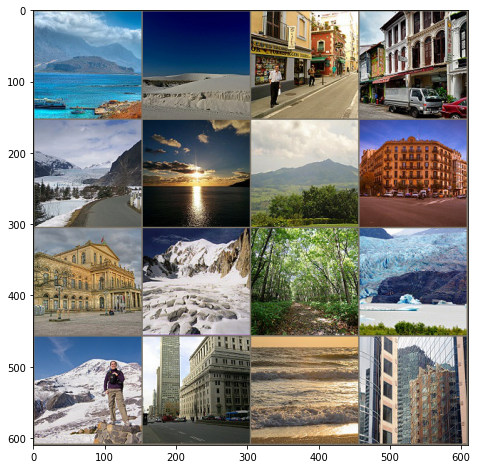

Predicted ['sea', 'sea', 'street', 'street', 'glacier', 'sea', 'mountain', 'buildings', 'buildings', 'glacier', 'forest', 'glacier', 'glacier', 'buildings', 'sea', 'buildings']
Actual ['sea', 'glacier', 'street', 'street', 'glacier', 'sea', 'mountain', 'buildings', 'buildings', 'glacier', 'forest', 'glacier', 'glacier', 'buildings', 'sea', 'buildings']


In [106]:
model.eval()
xx = xx[:16]
yy = yy[:16]
with torch.no_grad():
    out = model(xx.cuda())
    preds = out.argmax(1)
    predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
    actual_classes = [image_datasets['dev'].classes[c] for c in yy]
    imshow(make_grid(xx, nrow=4), fig_size=(8,8))
    print("Predicted", predicted_classes)
    print("Actual", actual_classes)

In [107]:
all_preds = []
correct_preds = []
with torch.no_grad():
    model.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = model(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [108]:
from sklearn import metrics

In [109]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [110]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.89      0.92      0.91       437
      forest       0.97      0.99      0.98       474
     glacier       0.86      0.80      0.83       553
    mountain       0.84      0.81      0.83       525
         sea       0.88      0.96      0.92       510
      street       0.92      0.89      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000



In [111]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,403,1,1,1,3,28
forest,0,467,2,3,0,2
glacier,1,4,445,69,30,4
mountain,1,2,61,427,30,4
sea,2,2,6,8,492,0
street,45,3,0,1,6,446
